# Population projections: taxcalc vs Census

This compares population totals between taxcalc and [Census projections](https://www.census.gov/data/datasets/2017/demo/popproj/2017-popproj.html) for the following fields:
* `XTOT` (total population)
* `nu05` (under 5)
* `nu13` (under 13)
* `n24` (children eligible for the Child Tax Credit, of which the primary condition is being under age 17)
* `nu18` (under 18)
* `n1820` (18-20)
* `n21` (21 or older)

*Data: CPS  |  Tax years: 2014-2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-03-20*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
# On Python 3.6 use "import urllib.request as url_lib".
import urllib as url_lib

In [2]:
tc.__version__

'0.17.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

### taxcalc

In [6]:
recs = tc.Records.cps_constructor()
pol = tc.Policy()

Include age 5 and 13 to match current code (see https://github.com/open-source-economics/taxdata/issues/164).

In [7]:
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
tc_pop = pd.DataFrame()
METRICS = pd.DataFrame(
    index=       ['XTOT', 'nu05', 'nu13', 'nu18', 'n1820', 'n21'],
    data={'min': [0     , 0     , 0     , 0     , 18     , 21   ],
          'max': [100   , 5     , 13    , 17    , 20     , 100  ]})
metric_cols = METRICS.index.tolist()

In [8]:
for i in range(2014, 2028):  # 2027 is the last modelable year.
    calc.advance_to_year(i)
    calc.calc_all()
    calc_df = calc.dataframe(['s006'] + metric_cols)
    for col in metric_cols:
        tc_pop.loc[i, col] = (calc_df.s006 * calc_df[col]).sum()

In [9]:
tc_pop_m = tc_pop / 1e6

### Census projections

In [10]:
census_raw = pd.read_csv('https://www2.census.gov/programs-surveys/popproj' +
                         '/datasets/2017/2017-popproj/np2017_d1.csv')

In [11]:
census = census_raw[(census_raw.SEX == 0) & (census_raw.ORIGIN == 0) &
                    (census_raw.RACE == 0)].drop(
    ['SEX', 'ORIGIN', 'RACE', 'TOTAL_POP'], axis=1).melt(
    id_vars='YEAR')
census.columns = ['year', 'age', 'pop']
census['age'] = census.age.str.replace('POP_', '').astype('int64')
census = census[census.year < 2028]

## Preprocessing

In [12]:
censust = pd.DataFrame(index=range(2016, 2028))
for i in metric_cols:
    tmp = census.loc[census.age.between(METRICS.loc[i, 'min'], 
                                        METRICS.loc[i, 'max']),
                     ['pop', 'year']].groupby('year').sum()
    tmp.columns = [i]
    censust = censust.merge(tmp, left_index=True, right_index=True)

In [13]:
censust_m = censust / 1e6
censust_m

,XTOT,nu05,nu13,nu18,n1820,n21
2016,323.13,23.96,56.88,73.64,12.75,236.74
2017,325.49,24.02,56.95,73.68,12.76,239.04
2018,327.85,24.13,57.00,73.66,12.87,241.32
2019,330.21,24.26,57.07,73.72,12.92,243.57
2020,332.55,24.39,57.13,73.88,12.87,245.81
2021,334.89,24.52,57.17,74.03,12.76,248.10
2022,337.22,24.68,57.23,74.16,12.75,250.32
2023,339.52,24.78,57.41,74.29,12.82,252.41
2024,341.80,24.86,57.59,74.40,12.90,254.51
2025,344.06,24.93,57.76,74.48,12.97,256.61


In [14]:
diff = pd.merge(censust_m, tc_pop_m, left_index=True, right_index=True)
for i in metric_cols:
    diff[i] = diff[i + '_y'] / diff[i + '_x'] - 1
diff[metric_cols]

,XTOT,nu05,nu13,nu18,n1820,n21
2016,8.14e-03,-8.91e-02,0.06,0.08,0.07,-1.86e-02
2017,1.43e-02,-7.90e-02,0.07,0.10,0.08,-1.50e-02
2018,2.06e-02,-7.10e-02,0.09,0.11,0.08,-1.11e-02
2019,2.70e-02,-6.36e-02,0.10,0.13,0.09,-7.01e-03
2020,3.35e-02,-5.60e-02,0.11,0.14,0.11,-2.77e-03
2021,4.02e-02,-4.83e-02,0.13,0.15,0.14,1.35e-03
2022,4.70e-02,-4.16e-02,0.14,0.17,0.15,5.89e-03
2023,5.39e-02,-3.25e-02,0.15,0.18,0.16,1.10e-02
2024,6.10e-02,-2.28e-02,0.17,0.19,0.17,1.62e-02
2025,6.83e-02,-1.23e-02,0.18,0.21,0.18,2.15e-02


## Plot

In [15]:
# Order from top to bottom to align with graph.
metric_cols_order = ['nu18', 'n1820', 'nu13', 'XTOT', 'n21', 'nu05']

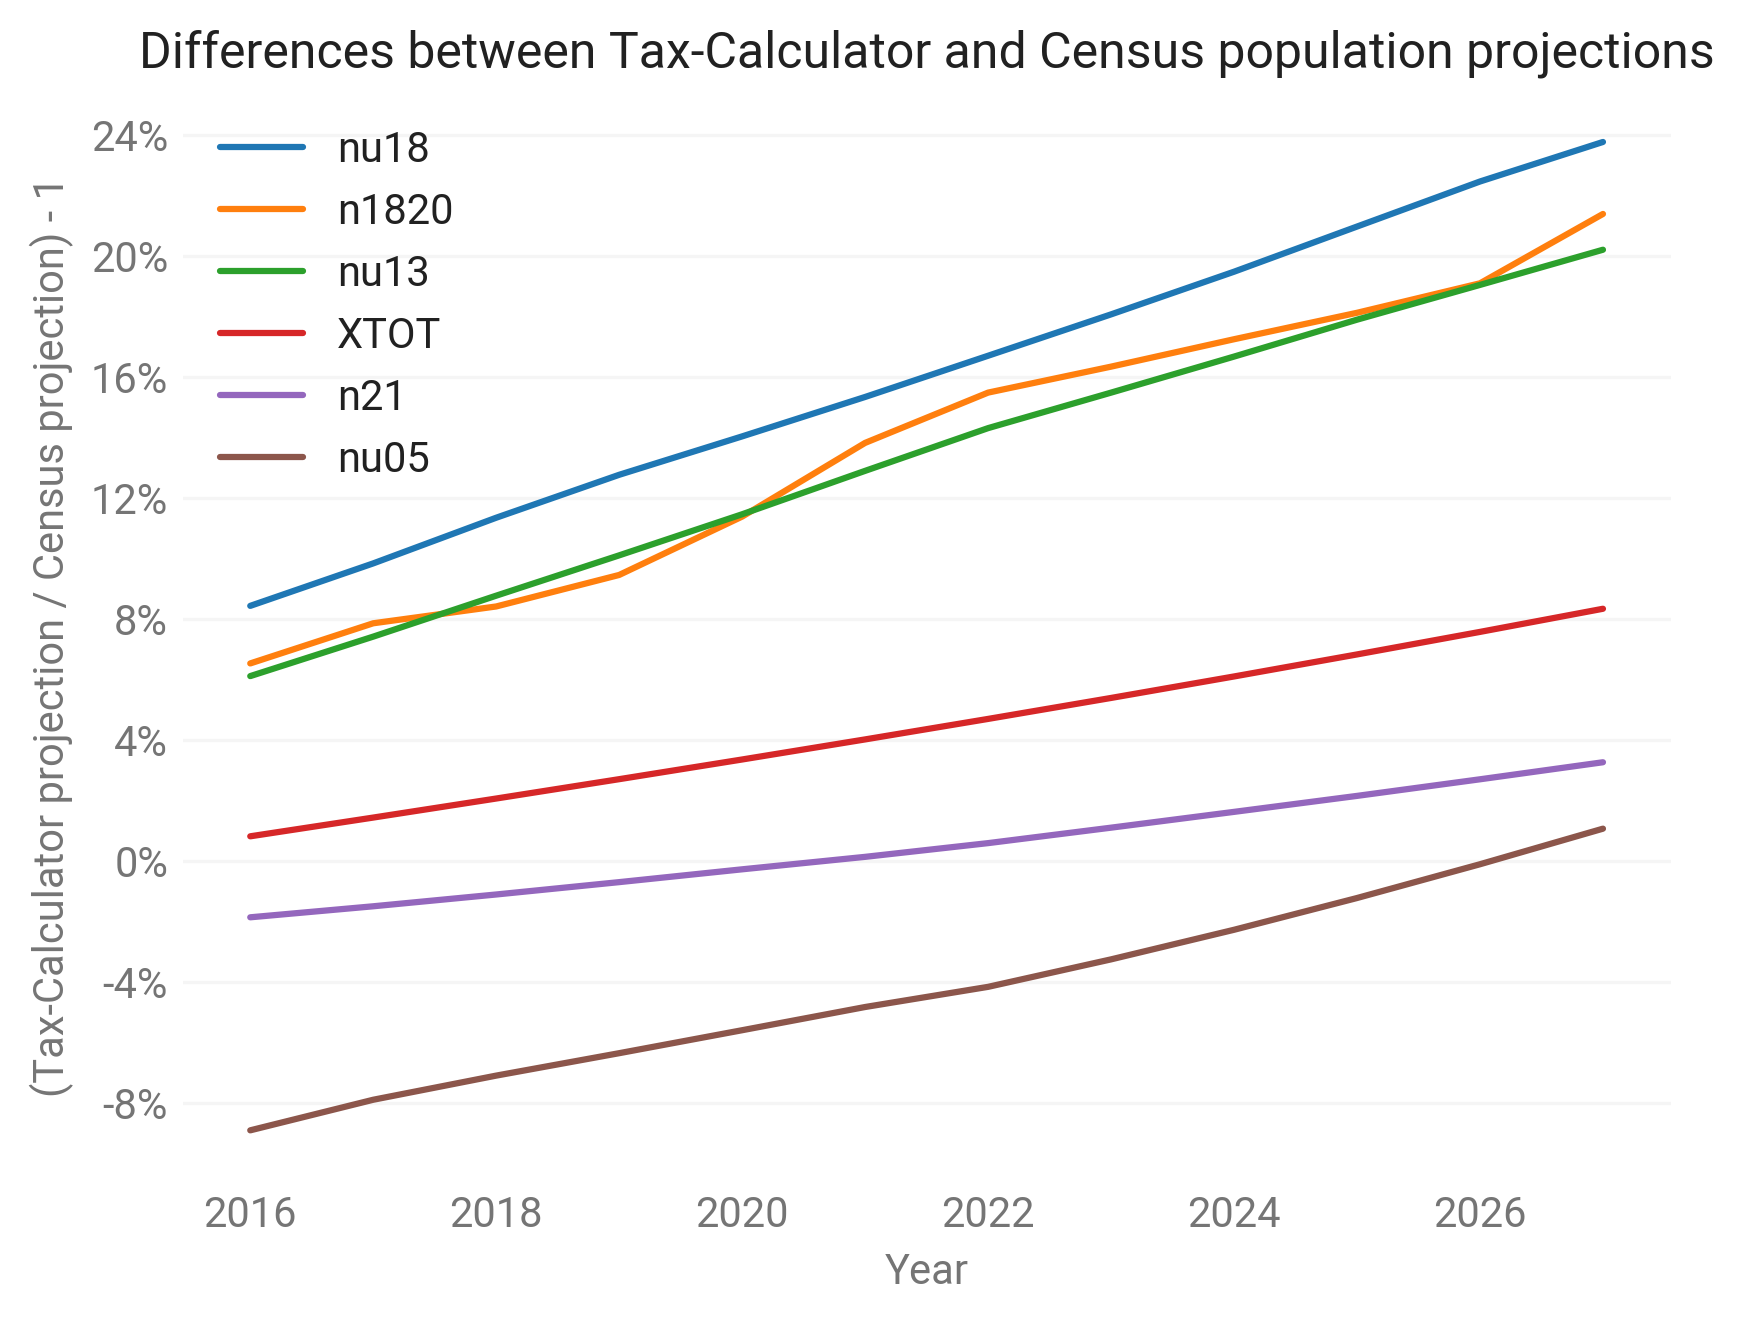

In [16]:
ax = diff[metric_cols_order].plot()
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
plt.title('Differences between Tax-Calculator and Census population' +
          ' projections')
ax.set(xlabel='Year',
       ylabel='(Tax-Calculator projection / Census projection) - 1')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
ax.grid(color='#f5f5f5', axis='y')
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
plt.show()

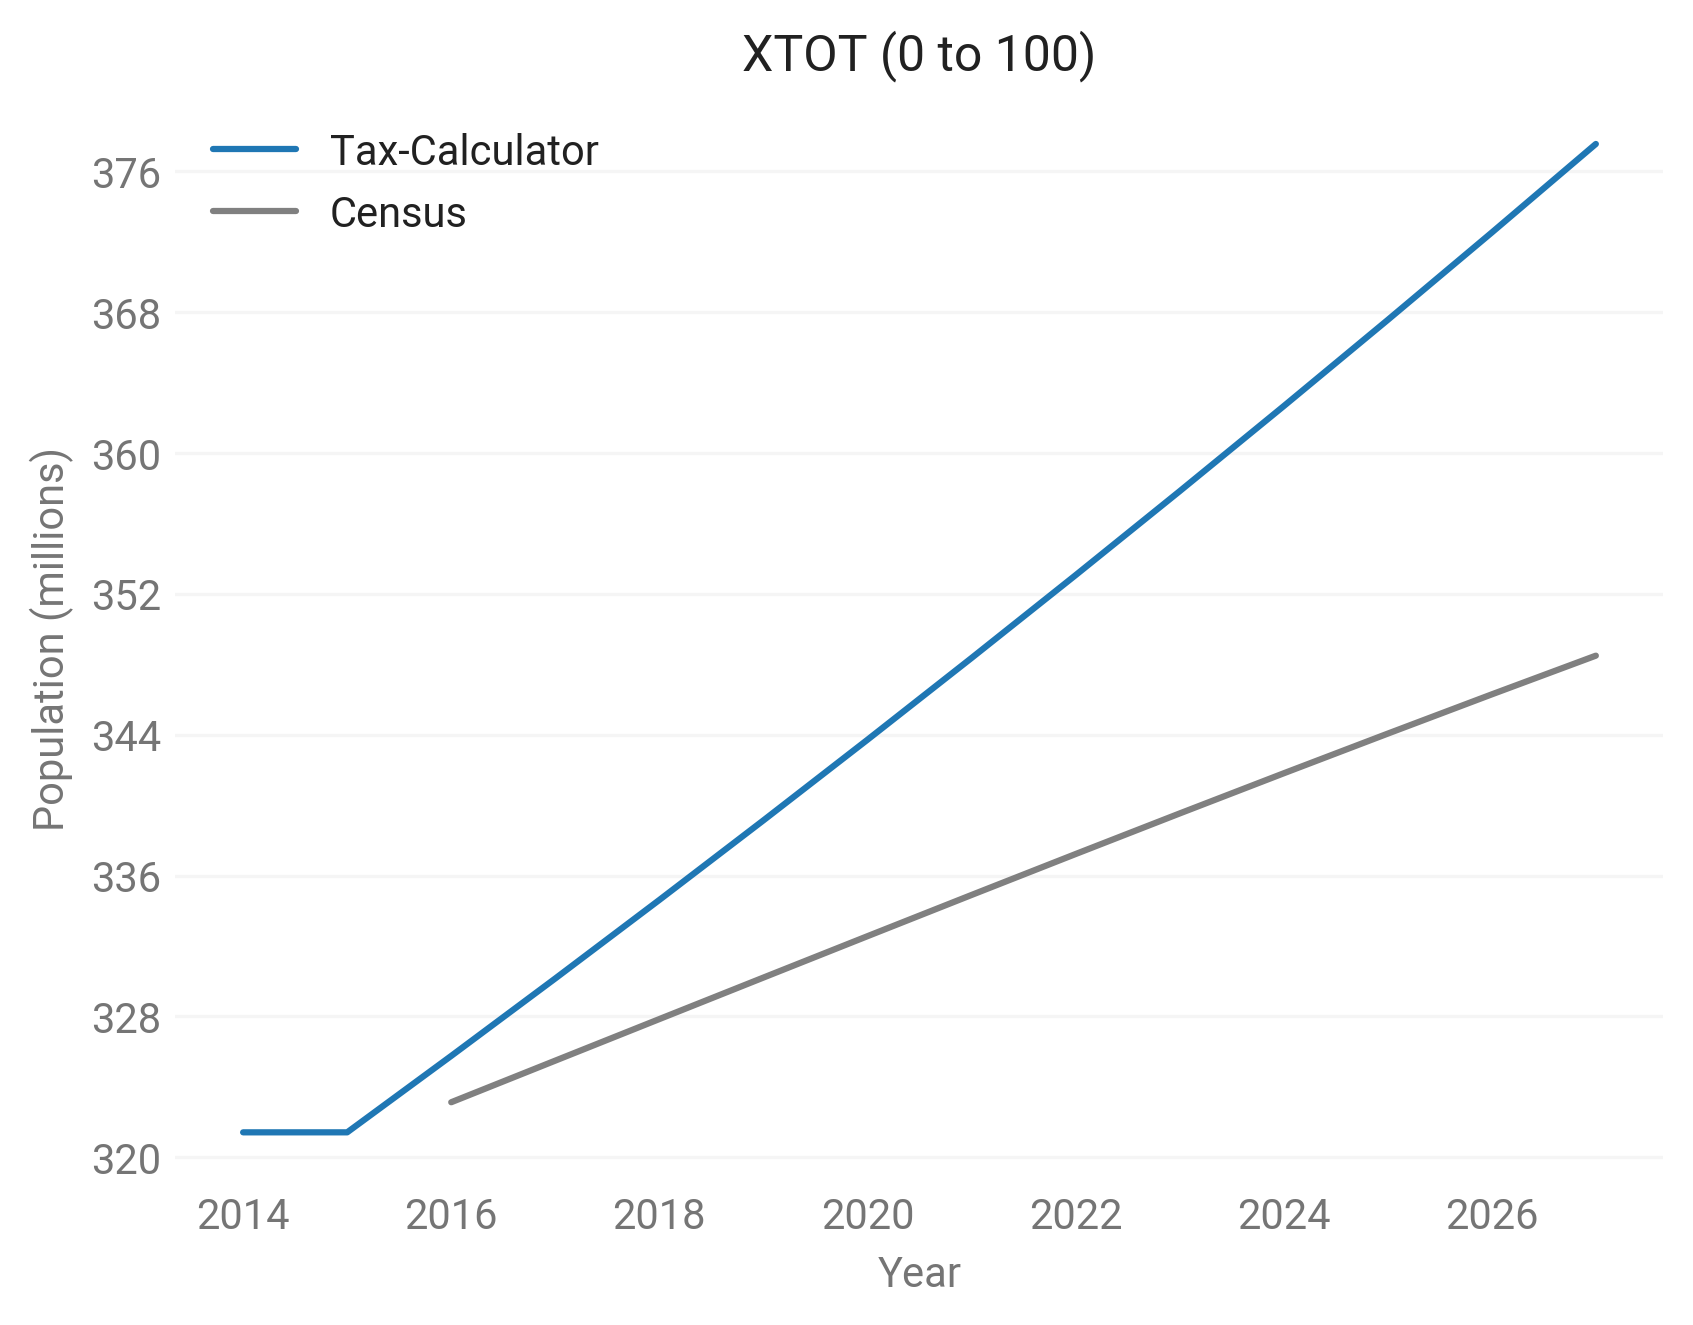

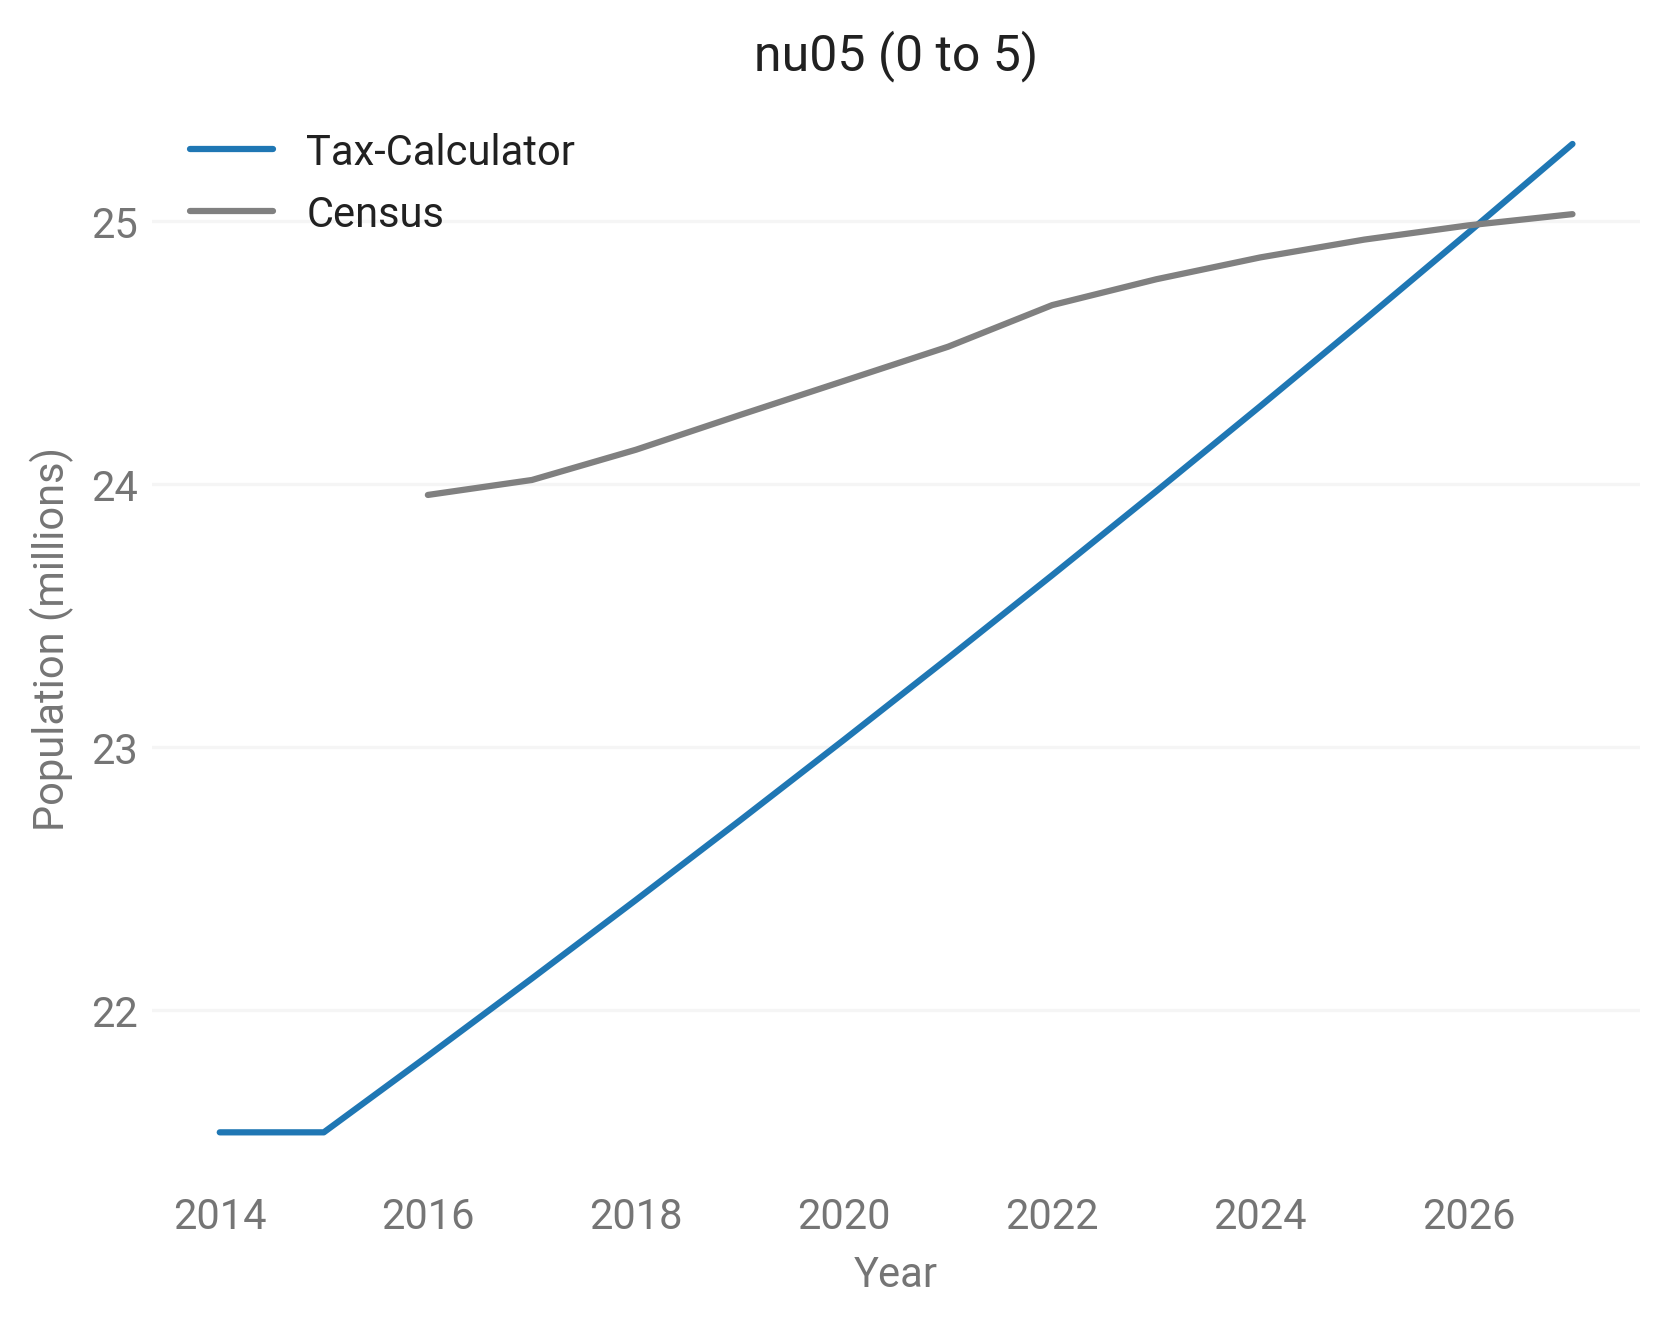

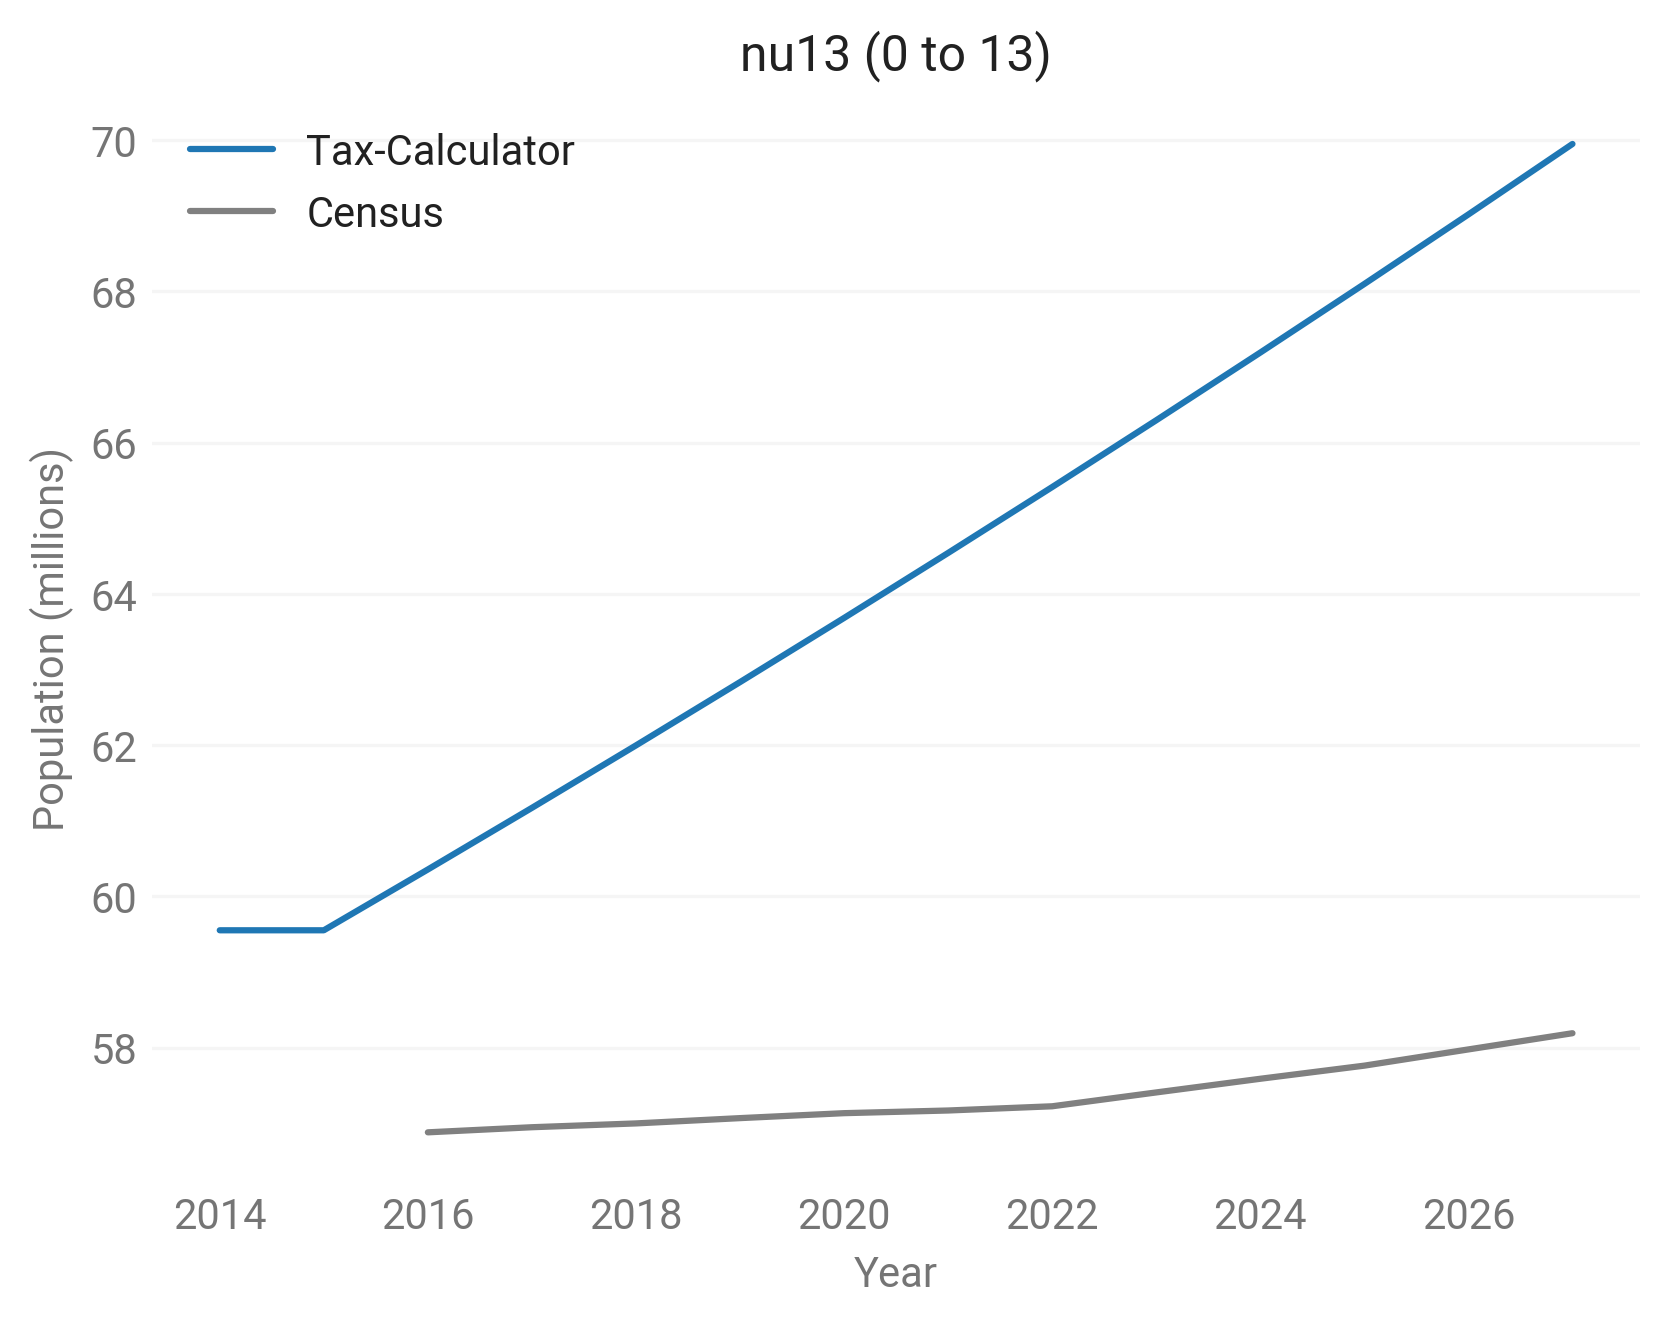

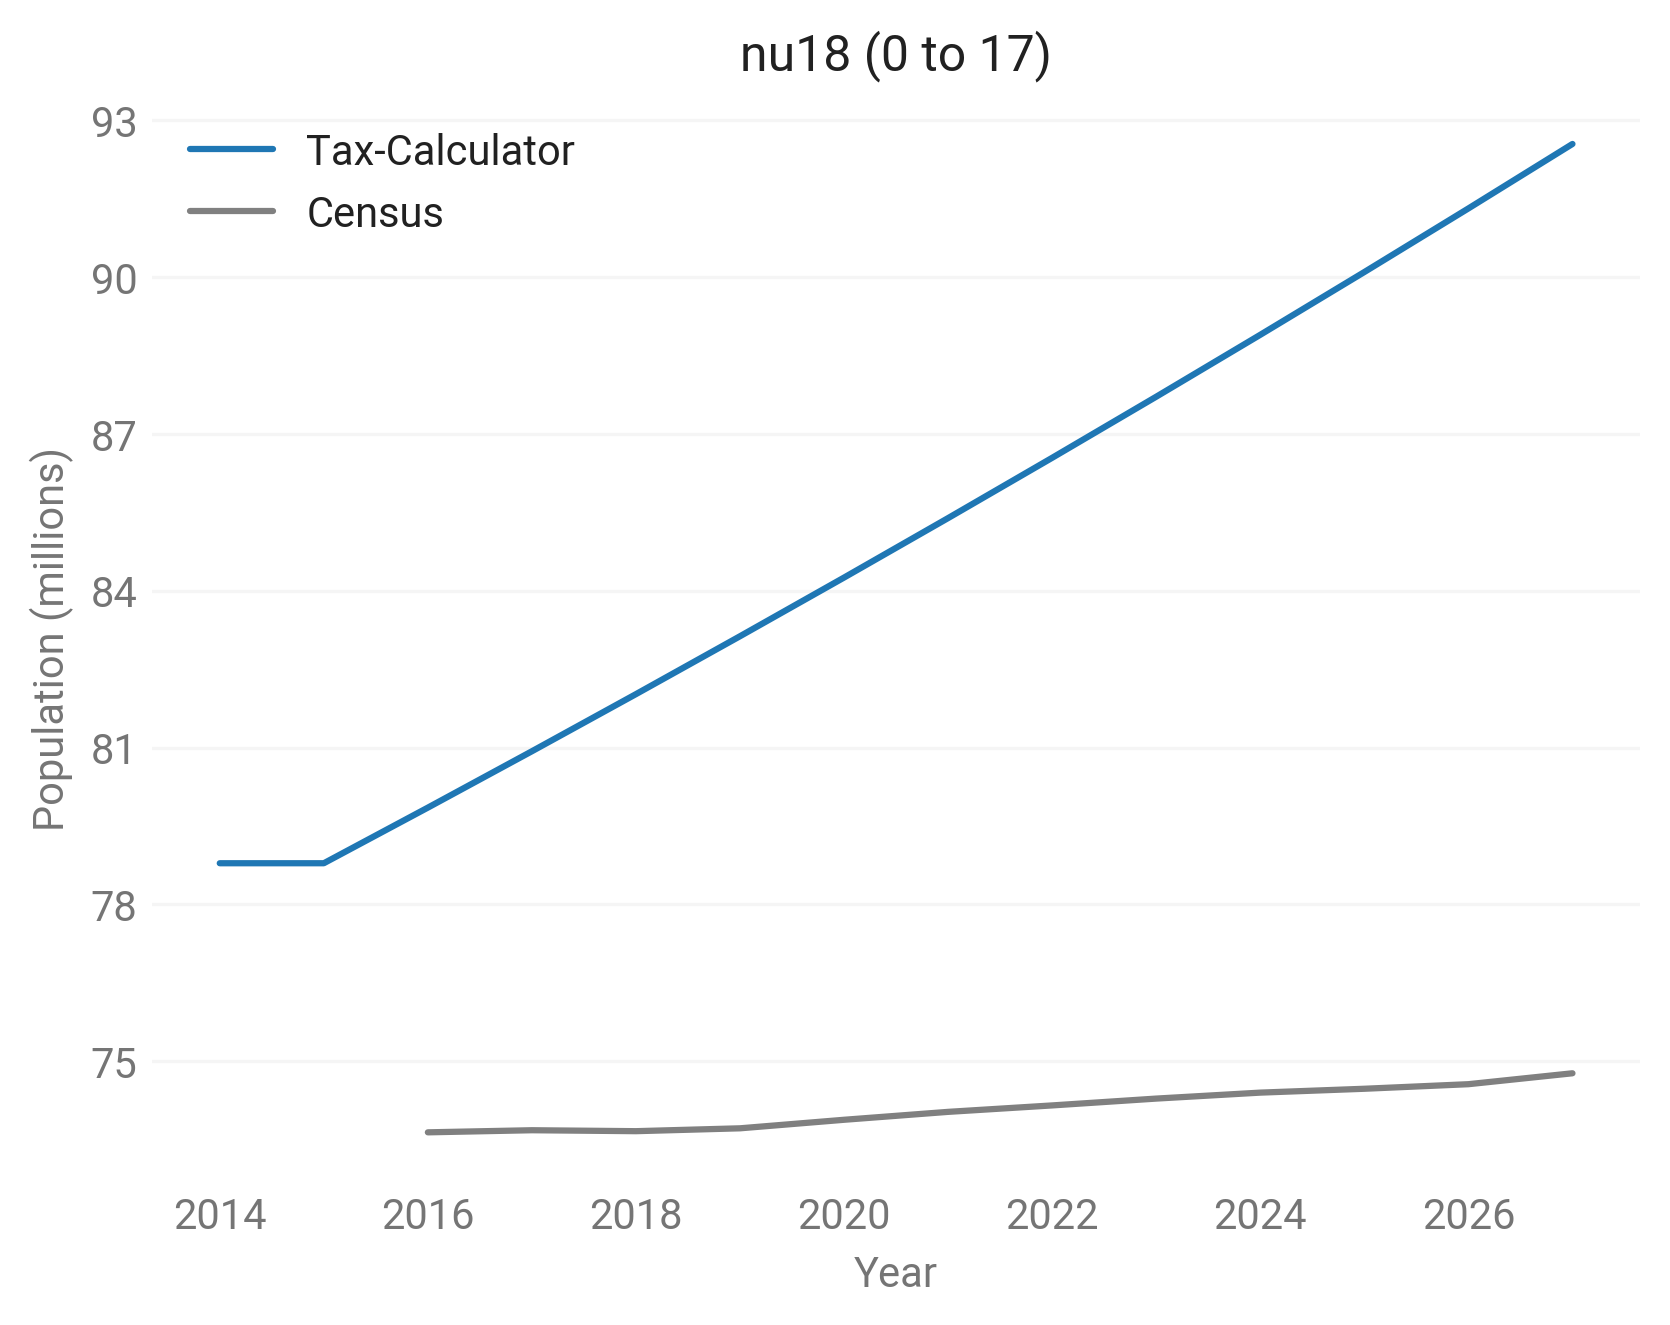

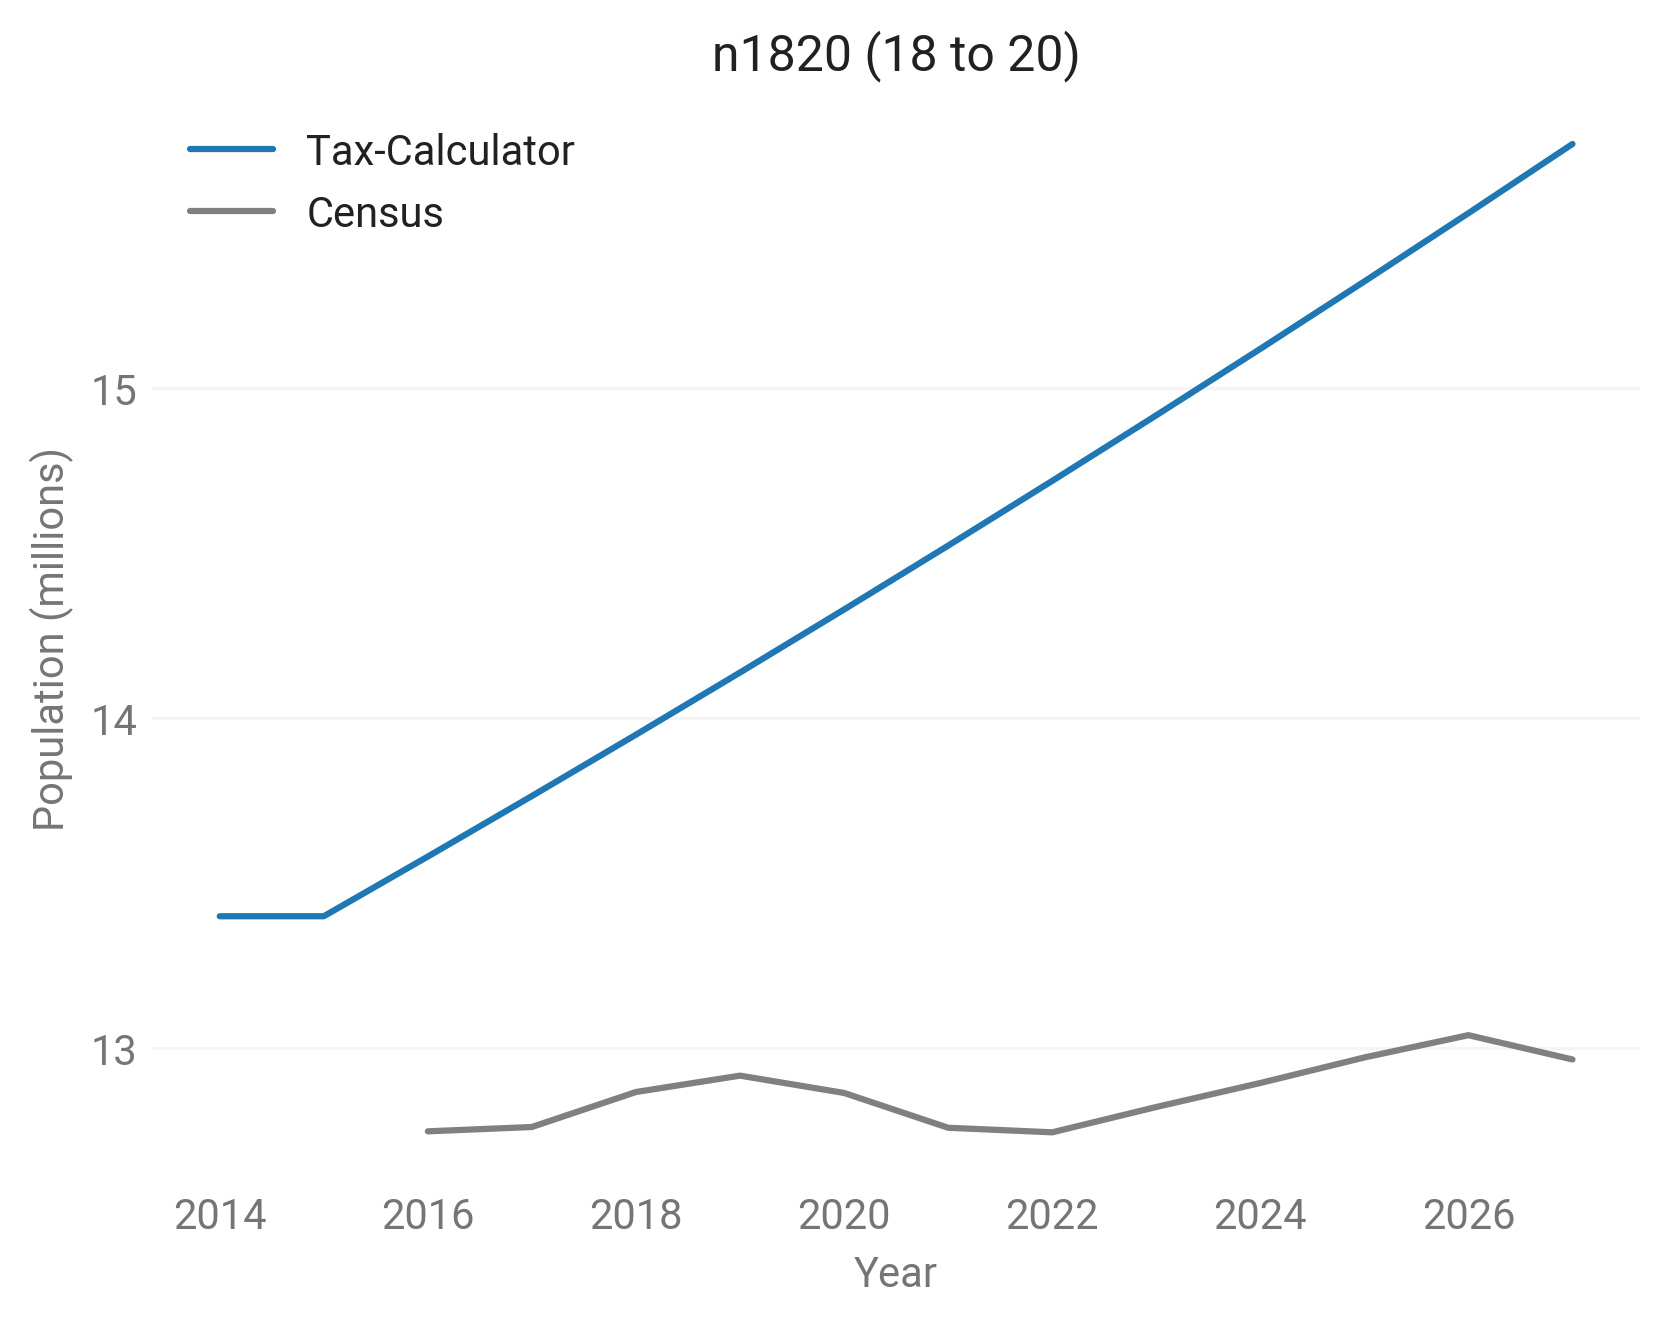

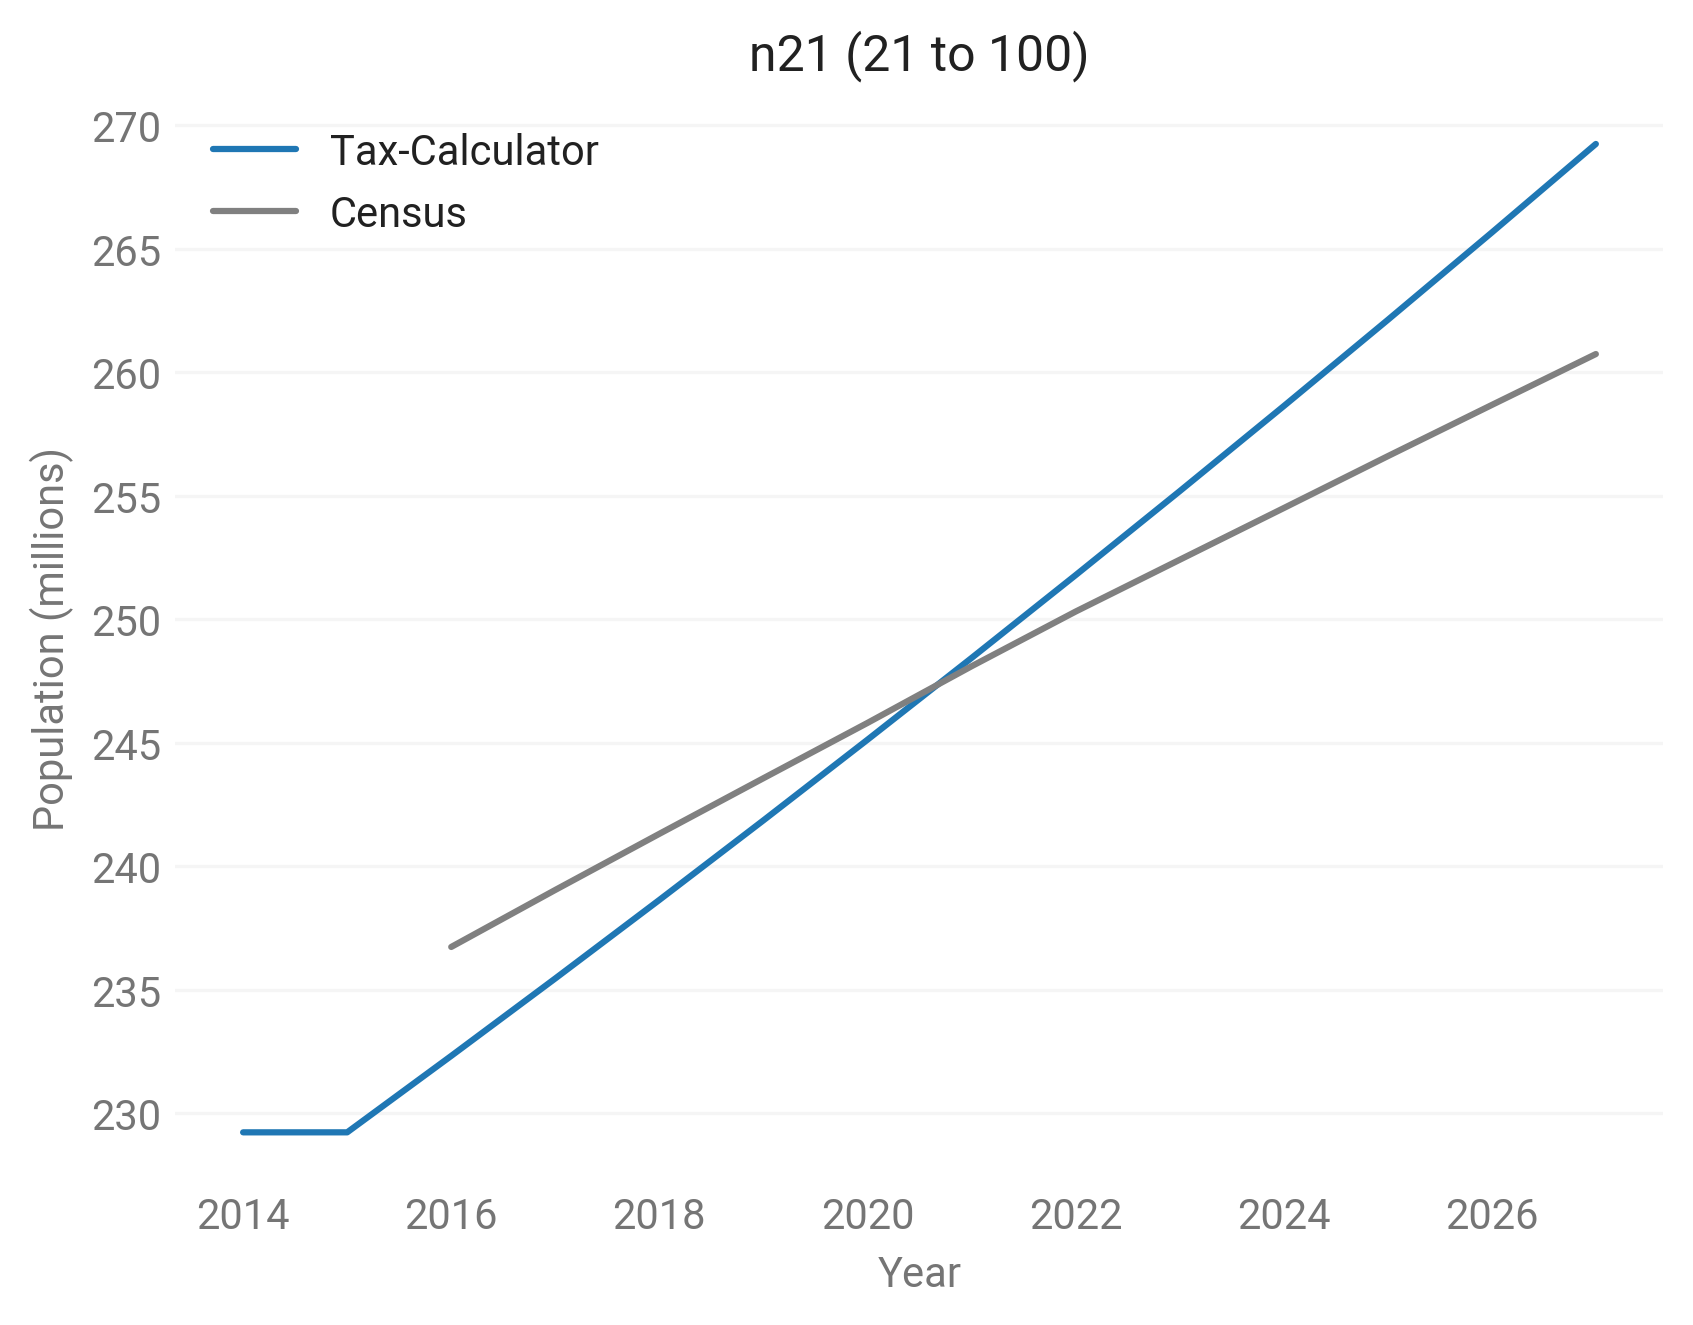

In [17]:
for i in range(len(metric_cols)):
    col = metric_cols[i]
    ax = tc_pop_m[col].plot(label='Tax-Calculator')
    censust_m[col].plot(ax=ax, color='gray', label='Census')
    plt.legend(frameon=False)
    sns.despine(left=True, bottom=True)
    plt.title(col + ' (' + str(METRICS.loc[col, 'min']) + ' to ' + 
              str(METRICS.loc[col, 'max']) + ')')
    ax.set(xlabel='Year',
           ylabel='Population (millions)')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(color='#f5f5f5', axis='y')
    plt.show()